In [52]:
# data visualiztion
import matplotlib.pyplot as plt
import seaborn as sns

# raw data handling
import pandas as pd
import numpy as np
import datetime as dt

# for linear regression models
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms 
from statsmodels.formula.api import ols
import scipy.stats as stats

# recursive feature elimination (w/ cross validation), linear regression
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression

# Variance inflation factor, mean abs/squarred error
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings # weird sns.distplot() warnings
warnings.filterwarnings("ignore")

# make stuff look cooler
plt.style.use('fivethirtyeight')

In [53]:
# creates dictionary of variance inflation factors. 
def create_vif_list(X):
    X = sm.add_constant(X)
    vif_dict = {}

    for i in range(len(X.columns)):
        vif = variance_inflation_factor(X.values, i)
        v = X.columns[i]
        vif_dict[v] = vif

    good_vifs = []
    bad_vifs = []

    for k,v in vif_dict.items():
        if v < 10:
            good_vifs.append(k)
        else:
            bad_vifs.append(k)

    return good_vifs,bad_vifs

def create_vif_dictionary(X):
    X = sm.add_constant(X)
    vif_dict = {}

    for i in range(len(X.columns)):
        vif = variance_inflation_factor(X.values, i)
        v = X.columns[i]
        vif_dict[v] = vif

    return vif_dict

# create a dictionary showing the adjusted R-squared values for each feature individually
def create_R2_dictionary(X,y):

    adj_R_squares = {}

    for feature in X.columns:
        predictors_int = sm.add_constant(X[feature])
        model = sm.OLS(y,predictors_int).fit()
        adj_R_square = float(model.summary2().tables[0][3][0])
        adj_R_squares[feature] = adj_R_square
        
    return adj_R_squares

# author's docstring is in a markup cell down below in the stepwise selection section
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    included = list(initial_list)

    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))
        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            worst_feature_name = included[worst_feature]
            included.pop(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature_name, worst_pval))
        if not changed:
            break
    return included

# recursive feature elimination
def run_RFE(X,y):

    linreg = LinearRegression()
    selector = RFE(linreg)
    selector = selector.fit(X, y)

    selected = selector.support_ # list of bools representing if feature is selected or not
    selections = [] # list of column names that are selected
    labels = list(X.columns) # list of all column names 

    for idx,feature in enumerate(selected): # append labels of selected features to selections list
        if feature == True:
            selections.append(labels[idx])
        else:
            pass
    
    ranked = selector.ranking_ # list of bools representing if feature is selected or not
    rankers = [] # list of column names that are selected
    labels = list(X.columns) # list of all column names 

    for idx,feature in enumerate(ranked): # append labels of selected features to selections list
        if feature == 1:
            rankers.append(labels[idx])
        else:
            pass
    return selections, rankers

# recuersive feature elimination with cross validation
def run_RFECV(X,y,select_rank=False):

    linreg = LinearRegression()
    selector = RFECV(linreg)
    selector = selector.fit(X, y)

    selected = selector.support_ # list of bools representing if feature is selected or not
    selections = [] # list of column names that are selected
    labels = list(X.columns) # list of all column names 

    for idx,feature in enumerate(selected): # append labels of selected features to selections list
        if feature == True:
            selections.append(labels[idx])
        else:
            pass
    
    ranked = selector.ranking_ # list of bools representing if feature is selected or not
    rankers = [] # list of column names that are selected
    labels = list(X.columns) # list of all column names 

    for idx,feature in enumerate(ranked): # append labels of selected features to selections list
        if feature == 1:
            rankers.append(labels[idx])
        else:
            pass

    if select_rank == True:
        return selections
    else:
        return rankers

# returns OLS linear regression model
def run_OLS_model(X,y):

    predictors_int = sm.add_constant(X)
    model = sm.OLS(y,predictors_int).fit()

    return model

# returns dictionary: keys are column labels, values are count of NaN values present
def create_NaN_dictionary(X):

    NaN_dict = {}

    for feature in X.columns:
        NaN_dict[feature] = sum(X[feature].isna())

    return NaN_dict

def create_CC_df(X,minimum=0,maximum=1):

    cor_df=X.corr().abs().stack().reset_index().sort_values(0, ascending=False)
    cor_df['pairs'] = list(zip(cor_df.level_0, cor_df.level_1))
    cor_df.set_index(['pairs'], inplace = True)
    cor_df.drop(columns=['level_1', 'level_0'], inplace = True)
    cor_df.columns = ['cc']
    cor_df.drop_duplicates(inplace=True)
    cor_df = cor_df[(cor_df.cc>minimum) & (cor_df.cc < maximum)]
    
    return cor_df

def model_strength_indicators(model):
    indicator_dict = {
    'r_squared':model.summary2().tables[0][3][0],
    'skew':model.summary2().tables[2][1][2],
    'kurtosis':model.summary2().tables[2][1][3],
    'Durbin Watson':model.summary2().tables[2][3][0],
    'Jarque-Bera':model.summary2().tables[2][3][1],
    'P value':model.summary2().tables[2][3][2],
    'Condition':model.summary2().tables[2][3][3]
    }
    return indicator_dict


#### Set up dataframe and deal with some missing data

In [54]:
X = pd.read_csv('data/kc_house_data.csv')
X.drop(X.loc[X['sqft_basement']=='?'].index,inplace=True) # remove '?' from the data.

##### Make object types numerical

In [55]:
# convert all string types into np floats
X.sqft_basement = [float(sq) for sq in list(X.sqft_basement)]

# Replaces grade strings with numerics based on data dict. 
grade_raws = list(X.grade.unique())
# replaces a cell value with the int of the first character of its existing string
for raw in grade_raws:
    X.grade.replace(to_replace=raw,value=int(raw[0]),inplace=True)

# replaces condition objects with numerics based on data dict.
condition_dict = {'Poor':1,'Fair':2,'Average':3,'Good':4,'Very Good':5}
for key in condition_dict:
    X.condition.replace(to_replace=condition_dict,inplace=True)

# replace yr_built NaNs with numeric 0
X.yr_renovated.replace(to_replace=np.nan,value=0,inplace=True)

# convert waterfront into numeric boolean
waterfront_bool_list = []

for value in X.waterfront:
    if value == 'YES':
        waterfront_bool_list.append(1)
    else:
        waterfront_bool_list.append(0)
        
X.waterfront = waterfront_bool_list

# convert view from string into categorical ordinal
view_rank_list = [] 
view_dict = {'NONE':0,'FAIR':1,'AVERAGE':2,'GOOD':3,'EXCELLENT':4}

for value in X.view:
    if value in list(view_dict.keys()):
        view_rank_list.append(view_dict[value])
    else:
        view_rank_list.append(0)
        
X.view = view_rank_list


# convert dates into ordinals 
X.date = pd.to_datetime(X['date'])
X.date = X['date'].map(dt.datetime.toordinal)

In [56]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21143 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21143 non-null  int64  
 1   date           21143 non-null  int64  
 2   price          21143 non-null  float64
 3   bedrooms       21143 non-null  int64  
 4   bathrooms      21143 non-null  float64
 5   sqft_living    21143 non-null  int64  
 6   sqft_lot       21143 non-null  int64  
 7   floors         21143 non-null  float64
 8   waterfront     21143 non-null  int64  
 9   view           21143 non-null  int64  
 10  condition      21143 non-null  int64  
 11  grade          21143 non-null  int64  
 12  sqft_above     21143 non-null  int64  
 13  sqft_basement  21143 non-null  float64
 14  yr_built       21143 non-null  int64  
 15  yr_renovated   21143 non-null  float64
 16  zipcode        21143 non-null  int64  
 17  lat            21143 non-null  float64
 18  long  

In [57]:
X.describe()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.114300e+04,21143.000000,2.114300e+04,21143.000000,21143.000000,21143.000000,2.114300e+04,21143.000000,21143.000000,21143.000000,...,21143.000000,21143.000000,21143.000000,21143.000000,21143.000000,21143.000000,21143.000000,21143.000000,21143.00000,21143.000000
mean,4.581004e+09,735535.367261,5.405107e+05,3.372558,2.116079,2080.920730,1.508714e+04,1.493591,0.006716,0.232654,...,6.946318,1789.069006,291.851724,1971.023223,68.256492,98077.868893,47.560274,-122.213876,1987.27139,12738.941967
std,2.876328e+09,113.117804,3.680751e+05,0.924917,0.768531,918.547562,4.120920e+04,0.539249,0.081679,0.764064,...,1.909355,828.409769,442.498337,29.321938,362.765827,53.535756,0.138591,0.140597,685.67034,27169.273663
min,1.000102e+06,735355.000000,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,...,1.000000,370.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.00000,651.000000
25%,2.123049e+09,735436.000000,3.220000e+05,3.000000,1.750000,1430.000000,5.043000e+03,1.000000,0.000000,0.000000,...,7.000000,1200.000000,0.000000,1952.000000,0.000000,98033.000000,47.471250,-122.328000,1490.00000,5100.000000
50%,3.904940e+09,735522.000000,4.500000e+05,3.000000,2.250000,1910.000000,7.620000e+03,1.500000,0.000000,0.000000,...,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.572000,-122.230000,1840.00000,7626.000000
75%,7.309100e+09,735647.000000,6.450000e+05,4.000000,2.500000,2550.000000,1.069550e+04,2.000000,0.000000,0.000000,...,8.000000,2210.000000,560.000000,1997.000000,0.000000,98117.000000,47.678200,-122.125000,2360.00000,10087.000000
max,9.900000e+09,735745.000000,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,...,9.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.00000,871200.000000


In [58]:
y = X.price
X = X.drop('price',axis=1)

First round of feature elimination

In [59]:
# stepwise feature elmination
stepwise_selected = stepwise_selection(X,y,verbose=False)
X_base = X[stepwise_selected]

In [60]:
# recursive feature elimination
RFE_selection = run_RFECV(X_base,y)
X_base = X_base[RFE_selection]

In [61]:
# inspecting multicolinearity 

# eliminate features base on variance inflation factor
good,bad = create_vif_list(X_base)
X_base = X_base[good]


In [62]:
cc_df = create_CC_df(X_base,.6,1)
cc_df

,cc
pairs,
"(sqft_lot15, sqft_lot)",0.720649


#### Create and visualize base model

In [63]:
base_model = run_OLS_model(X_base,y)
base_resid = base_model.resid

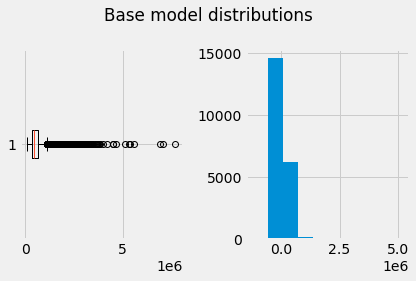

In [64]:
fig,(ax1,ax2) = plt.subplots(1,2)

ax1.boxplot(y,vert=False)
ax2.hist(base_resid)

fig.suptitle("Base model distributions")

plt.tight_layout()
plt.show()

In [65]:
base_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.626
Model:                            OLS   Adj. R-squared:                  0.626
Method:                 Least Squares   F-statistic:                     2215.
Date:                Tue, 05 Apr 2022   Prob (F-statistic):               0.00
Time:                        14:17:04   Log-Likelihood:            -2.9056e+05
No. Observations:               21143   AIC:                         5.812e+05
Df Residuals:                   21126   BIC:                         5.813e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -8.358e+07   1.06e+07     -7.860      0.000   -1.04e+08   -6.27e+07
waterfront     6.267e+05   2.05e+04     30.512      0.000    5.86e+05    6.67e+05
lat            6.974e+05   1.19e+04     58.514      0.000    6.74e+05    7.21e+05
view           6.842e+04   2355.000     29.053      0.000    6.38e+04     7.3e+04
grade         -3.494e+04    849.237    -41.141      0.000   -3.66e+04   -3.33e+04
yr_built      -1960.9853     79.610    -24.632      0.000   -2117.027   -1804.944
bathrooms       1.49e+05   3205.149     46.499      0.000    1.43e+05    1.55e+05
bedrooms       3103.0581   2023.010      1.534      0.125    -862.196    7068.313
sqft_living15   183.4221      3.093     59.312      0.000     177.361     189.484
long          -2.904e+05   1.45e+04    -20.016      0.000   -3.19e+05   -2.62e+05
zipcode        -607.4109     37.224    -16.318      0.000    -680.373    -534.449
condition      3.615e+04   2650.017     13.643      0.000     3.1e+04    4.13e+04
floors         5.727e+04   3598.796     15.914      0.000    5.02e+04    6.43e+04
yr_renovated     43.9563      4.511      9.745      0.000      35.115      52.797
date            106.3436     13.727      7.747      0.000      79.437     133.250
sqft_lot15       -0.2083      0.083     -2.498      0.012      -0.372      -0.045
sqft_lot          0.3537      0.054      6.493      0.000       0.247       0.460
==============================================================================
Omnibus:                    18937.321   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2358627.117
Skew:                           3.821   Prob(JB):                         0.00
Kurtosis:                      54.175   Cond. No.                     5.10e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.1e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

##### Observations:

Data is clearly not normally distributed. First investigate elmination of outliers in the target variable and then log transformation. 

In [66]:
# eliminating all records where target variable is more than three standard deviations from its mean 
std_thresh = y.std()*3 # three standard deviations
Xy = pd.concat([X_base,y],axis=1)
std_cap = Xy.loc[abs(Xy['price']) <= std_thresh]

y = std_cap.price
X_outlier = std_cap.drop('price',axis=1)

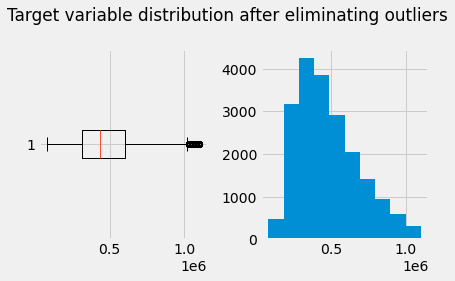

In [67]:
fig,(ax1,ax2) = plt.subplots(1,2)

ax1.boxplot(y,vert=False)
ax2.hist(y)

fig.suptitle("Target variable distribution after eliminating outliers")
plt.tight_layout()
plt.show()

Inspect resulting model 

In [68]:
outlier_model = run_OLS_model(X_outlier,y)
outlier_residual = outlier_model.resid

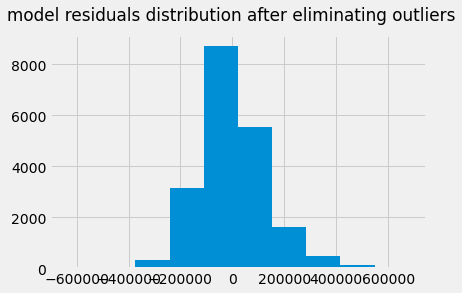

In [69]:
# visualize model residuals
plt.hist(outlier_residual)
plt.suptitle('model residuals distribution after eliminating outliers')
plt.show()

In [70]:
outlier_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.607
Model:                            OLS   Adj. R-squared:                  0.607
Method:                 Least Squares   F-statistic:                     1928.
Date:                Tue, 05 Apr 2022   Prob (F-statistic):               0.00
Time:                        14:17:06   Log-Likelihood:            -2.6358e+05
No. Observations:               19982   AIC:                         5.272e+05
Df Residuals:                   19965   BIC:                         5.273e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -6.772e+07   6.31e+06    -10.729      0.000   -8.01e+07   -5.53e+07
waterfront     9.131e+04   1.92e+04      4.765      0.000    5.38e+04    1.29e+05
lat            6.004e+05   6959.409     86.273      0.000    5.87e+05    6.14e+05
view           3.697e+04   1576.204     23.457      0.000    3.39e+04    4.01e+04
grade         -2593.0065    597.419     -4.340      0.000   -3763.997   -1422.016
yr_built      -1359.6033     48.324    -28.135      0.000   -1454.322   -1264.885
bathrooms      7.377e+04   1996.342     36.952      0.000    6.99e+04    7.77e+04
bedrooms       5404.8429   1204.950      4.486      0.000    3043.041    7766.644
sqft_living15   146.1240      1.956     74.690      0.000     142.289     149.959
long          -9.165e+04   8542.521    -10.728      0.000   -1.08e+05   -7.49e+04
zipcode        -206.9797     22.137     -9.350      0.000    -250.370    -163.589
condition      3.088e+04   1575.017     19.609      0.000    2.78e+04     3.4e+04
floors         5.632e+04   2158.547     26.093      0.000    5.21e+04    6.06e+04
yr_renovated     25.8140      2.815      9.170      0.000      20.296      31.332
date             69.0492      8.148      8.474      0.000      53.078      85.020
sqft_lot15       -0.0531      0.050     -1.062      0.288      -0.151       0.045
sqft_lot          0.3394      0.032     10.470      0.000       0.276       0.403
==============================================================================
Omnibus:                     1515.152   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2435.491
Skew:                           0.589   Prob(JB):                         0.00
Kurtosis:                       4.241   Cond. No.                     5.11e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.11e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Observations: Indicators of normality slightly improved but its still worth exploring log transforming the target variable

In [71]:
y_log = np.log(y)

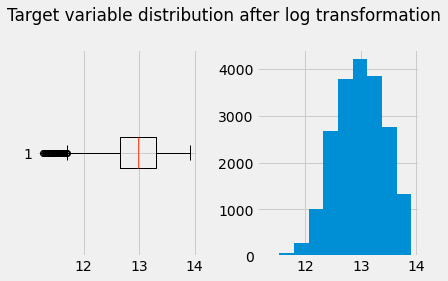

In [72]:
fig,(ax1,ax2) = plt.subplots(1,2)

ax1.boxplot(y_log,vert=False)
ax2.hist(y_log)

fig.suptitle("Target variable distribution after log transformation")
plt.tight_layout()
plt.show()

In [73]:
# eliminate outliers? 

In [74]:
stepwise_selected = stepwise_selection(X_outlier,y)
X_outlier = X_outlier[stepwise_selected]

Add  floors                         with p-value 0.0
Add  bathrooms                      with p-value 0.0
Add  lat                            with p-value 0.0
Add  sqft_living15                  with p-value 0.0
Add  yr_built                       with p-value 0.0
Add  view                           with p-value 3.07871e-145
Add  condition                      with p-value 1.39499e-77
Add  sqft_lot                       with p-value 5.40308e-34
Add  yr_renovated                   with p-value 1.17028e-17
Add  date                           with p-value 2.84157e-17
Add  long                           with p-value 1.31405e-13
Add  zipcode                        with p-value 1.75746e-20
Add  waterfront                     with p-value 2.44623e-06
Add  bedrooms                       with p-value 2.31633e-05
Add  grade                          with p-value 1.50062e-05


In [75]:
RFE_selection = run_RFECV(X_outlier,y)
X_outlier = X_outlier[RFE_selection]

In [76]:
good,bad = create_vif_list(X_outlier)
X_outlier = X_outlier[good]

In [77]:
outlier_cor_df = create_CC_df(X_outlier,.6,1)
outlier_cor_df

,cc
pairs,


In [78]:
log_model = run_OLS_model(X_outlier,y_log)
log_residuals = log_model.resid

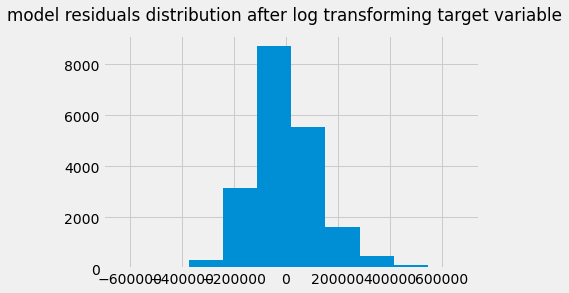

In [79]:
# visualize model residuals
plt.hist(outlier_residual)
plt.suptitle('model residuals distribution after log transforming target variable')
plt.show()

In [80]:
log_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.635
Model:                            OLS   Adj. R-squared:                  0.635
Method:                 Least Squares   F-statistic:                     2315.
Date:                Tue, 05 Apr 2022   Prob (F-statistic):               0.00
Time:                        14:17:14   Log-Likelihood:                -2064.8
No. Observations:               19982   AIC:                             4162.
Df Residuals:                   19966   BIC:                             4288.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          -154.7449     13.066    -11.843      0.000    -180.356    -129.134
floors            0.1182      0.004     26.474      0.000       0.109       0.127
bathrooms         0.1622      0.004     39.257      0.000       0.154       0.170
lat               1.4735      0.014    102.307      0.000       1.445       1.502
sqft_living15     0.0003   4.04e-06     72.369      0.000       0.000       0.000
yr_built         -0.0025      0.000    -25.120      0.000      -0.003      -0.002
view              0.0687      0.003     21.059      0.000       0.062       0.075
condition         0.0695      0.003     21.319      0.000       0.063       0.076
sqft_lot       7.563e-07   4.91e-08     15.416      0.000     6.6e-07    8.52e-07
yr_renovated   4.641e-05   5.83e-06      7.964      0.000     3.5e-05    5.78e-05
date              0.0002   1.69e-05      9.707      0.000       0.000       0.000
long             -0.1560      0.018     -8.857      0.000      -0.191      -0.121
zipcode          -0.0004   4.58e-05     -8.539      0.000      -0.000      -0.000
waterfront        0.2307      0.040      5.817      0.000       0.153       0.308
bedrooms          0.0137      0.002      5.475      0.000       0.009       0.019
grade             0.0119      0.001      9.588      0.000       0.009       0.014
==============================================================================
Omnibus:                      337.960   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              557.856
Skew:                          -0.154   Prob(JB):                    7.29e-122
Kurtosis:                       3.759   Cond. No.                     5.11e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.11e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Observations: After eliminating outliers, log transforming the target variable, and another round of feature selection and elimination. The model continues to improve. Next steps will be to Engineer new features and test how they impact the model performance. First new features will be engineered by joining a new dataset. Then features will be engineered from the remaing features from the principal dataset. 

##### Begin engineering new features to further improve the model

Features created from joining external data

In [81]:
X = X_outlier # reasigning X for readability 

In [82]:
water_loc_dict = {'Duwamish':[98168],
'Elliott Bay':[98119,98104,98129,98132,98127,98125,98195,98101,98134,98170,98139,98131,98181], 
'Puget Sound':[98071,98083,98013,98070,98031,98131,98063,98195,98207,98190], 
'Lake Union':[98109], 
'Ship Canal':[00000], 
'Lake Washington':[98072,98077], 
'Lake Sammamish':[98074,98075,98029], 
'other lake':[00000], 
'river/slough waterfronts':[00000]}

# list to contain new column data
waterfront_list = []

# for loop to assign waterfront based on zipcode
for zipcode in X.zipcode:
    for k,v in water_loc_dict.items():
        if zipcode in v:
            waterfront_list.append(k)
            appended = True
            break
        else: 
            appended = False
    if not appended:
        waterfront_list.append('NONE')

# print(len(waterfront_list),set(waterfront_list))
X['waterfront_loc'] = waterfront_list

In [83]:
income = pd.read_csv('data/irs_income_by_zipcode.csv')

income.avg_taxable_income = income.avg_taxable_income*1000 # scaling data back to dollar units (was in thousands)
income.taxable_income_amount = income.taxable_income_amount*1000 
income.rename({'taxable_income_amount':'zip_tax_revenue'},axis=1,inplace=True) # renaming to something more idiomatic

# # create lists to stage data in order to concat new columns later
joint_filing_bracket = [] #for the joint filing tax schedule


for average in income.avg_taxable_income:
    if average > 628301:
        joint_filing_bracket.append(7)
    elif average <= 19900:
        joint_filing_bracket.append(1)
    elif (average >= 19901) and (average <= 81050):
        joint_filing_bracket.append(2)
    elif (average >= 81051) and (average <= 172750):
        joint_filing_bracket.append(3)
    elif (average >= 172751) and (average <= 329850):
        joint_filing_bracket.append(4)
    elif (average >= 329851) and (average <= 418850):
        joint_filing_bracket.append(5)
    elif (average >= 418851) and (average <= 628300):
        joint_filing_bracket.append(6)

# assign discovered data to new column
income['joint_filing_tax_bracket'] = joint_filing_bracket

# create dictionary of zipcodes with corresponding tax bracket
# dictionary will be used to assign create similar columns in the principal data.
joint_filing_tax_dict = {}
tax_revenue_dict = {}

# create ditionaries to later assign values to principal data
for row in income.iterrows():
    joint_filing_tax_dict[row[1][0]] = row[1][3]
    tax_revenue_dict[row[1][0]] = row[1][1]

# concat columns to X containing tax bracket based on single and joint filing federal income tax schedule
X['income_tax_bracket'] = X.zipcode.replace(to_replace=joint_filing_tax_dict) # joint filing
X['zip_tax_revenue'] = X.zipcode.replace(to_replace=tax_revenue_dict)


In [84]:
# dropping zipcode since it is highly categorical and has now been extrapolated to other features. 
X.drop('zipcode',axis=1,inplace=True)

In [85]:
# create dummy variables
waterfront_dummies = pd.get_dummies(X.waterfront_loc,prefix='waterfront',prefix_sep='_').drop('waterfront_NONE',axis=1)
bracket_dummies = pd.get_dummies(X.income_tax_bracket,drop_first=True,prefix='income_tax',prefix_sep='_')

# reasign X to concatenated dataframe, dropping features no longer needed
X = X.drop(['waterfront_loc'],axis=1)
X = pd.concat([X,bracket_dummies,waterfront_dummies],axis=1)

Created new model and inspect perfromance

In [86]:
stepwise_selections = stepwise_selection(X,y_log)
X = X[stepwise_selections]

Add  zip_tax_revenue                with p-value 0.0
Add  floors                         with p-value 0.0
Add  bathrooms                      with p-value 0.0
Add  income_tax_bracket             with p-value 0.0
Add  lat                            with p-value 0.0
Add  sqft_living15                  with p-value 0.0
Add  yr_built                       with p-value 0.0
Add  view                           with p-value 4.84279e-210
Add  condition                      with p-value 7.77095e-75
Add  sqft_lot                       with p-value 1.91436e-73
Add  waterfront_Lake Washington     with p-value 1.31547e-67
Add  long                           with p-value 1.97404e-61
Add  waterfront_Duwamish            with p-value 5.3691e-51
Add  date                           with p-value 4.99627e-32
Add  bedrooms                       with p-value 4.80074e-27
Add  yr_renovated                   with p-value 7.64965e-18
Add  waterfront                     with p-value 2.73024e-14
Add  grade         

In [87]:
rfecv_selections = run_RFECV(X,y_log)
X = X[rfecv_selections]

In [88]:
good,bad = create_vif_list(X)
X = X[good[1:]]

In [89]:
hot_model = run_OLS_model(X,y_log)
hot_residuals = hot_model.resid

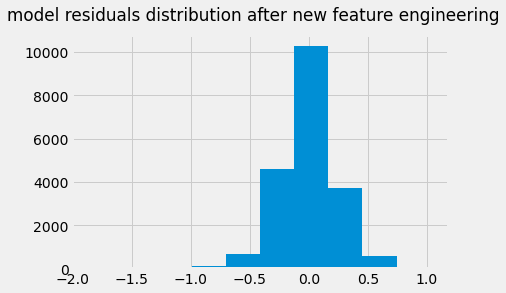

In [90]:
plt.hist(hot_residuals)
plt.suptitle('model residuals distribution after new feature engineering')
plt.show()

In [91]:
hot_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.721
Model:                            OLS   Adj. R-squared:                  0.721
Method:                 Least Squares   F-statistic:                     2246.
Date:                Tue, 05 Apr 2022   Prob (F-statistic):               0.00
Time:                        14:17:30   Log-Likelihood:                 633.81
No. Observations:               19982   AIC:                            -1220.
Df Residuals:                   19958   BIC:                            -1030.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                       -197.5295     11.029    -17.911      0.000    -219.147    -175.912
zip_tax_revenue             7.409e-11   3.65e-12     20.324      0.000    6.69e-11    8.12e-11
floors                         0.0996      0.004     25.516      0.000       0.092       0.107
bathrooms                      0.1493      0.004     41.223      0.000       0.142       0.156
income_tax_bracket             0.1968      0.006     31.731      0.000       0.185       0.209
lat                            1.0240      0.015     69.449      0.000       0.995       1.053
sqft_living15                  0.0002   3.63e-06     65.604      0.000       0.000       0.000
yr_built                      -0.0017   8.78e-05    -19.519      0.000      -0.002      -0.002
view                           0.0699      0.003     24.497      0.000       0.064       0.075
condition                      0.0591      0.003     20.688      0.000       0.053       0.065
sqft_lot                    1.039e-06   4.34e-08     23.926      0.000    9.54e-07    1.12e-06
waterfront_Lake Washington    -0.2007      0.012    -16.430      0.000      -0.225      -0.177
long                          -0.2668      0.015    -18.200      0.000      -0.296      -0.238
waterfront_Duwamish           -0.2163      0.015    -14.568      0.000      -0.245      -0.187
date                           0.0002   1.47e-05     12.053      0.000       0.000       0.000
bedrooms                       0.0238      0.002     10.900      0.000       0.020       0.028
yr_renovated                4.176e-05    5.1e-06      8.194      0.000    3.18e-05    5.17e-05
waterfront                     0.2798      0.035      8.015      0.000       0.211       0.348
grade                          0.0080      0.001      7.383      0.000       0.006       0.010
waterfront_Lake Union          0.1555      0.026      5.931      0.000       0.104       0.207
waterfront_Lake Sammamish      0.0396      0.008      4.715      0.000       0.023       0.056
waterfront_Elliott Bay         0.0508      0.011      4.823      0.000       0.030       0.071
waterfront_Puget Sound        -0.0370      0.013     -2.955      0.003      -0.062      -0.012
income_tax_3.0                 0.0167      0.006      2.583      0.010       0.004       0.029
==============================================================================
Omnibus:                      786.377   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2261.552
Skew:                          -0.132   Prob(JB):                         0.00
Kurtosis:                       4.627   Cond. No.                     8.37e+12
==============================================================================

Notes:
[1] Standard Errors assume that the 

In [92]:
hot_dict = model_strength_indicators(hot_model)
hot_dict

{'r_squared': '0.721',
 'skew': '-0.132',
 'kurtosis': '4.627',
 'Durbin Watson': '1.991',
 'Jarque-Bera': '2261.552',
 'P value': '0.000',
 'Condition': '8370405319230'}

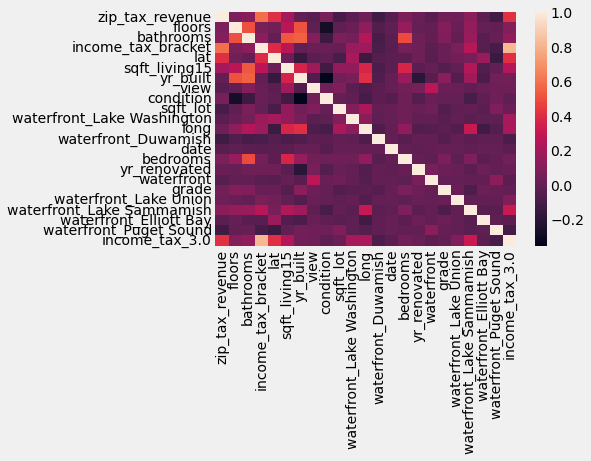

In [93]:
cor = X.corr()
sns.heatmap(cor,xticklabels=cor.columns,
        yticklabels=cor.columns)
plt.show()

In [94]:
correlations = create_CC_df(X,minimum=0.5)

In [95]:
correlations

,cc
pairs,
"(income_tax_3.0, income_tax_bracket)",0.819029
"(zip_tax_revenue, income_tax_bracket)",0.591402
"(yr_built, bathrooms)",0.546328
"(sqft_living15, bathrooms)",0.528819
"(floors, yr_built)",0.511731
"(bathrooms, floors)",0.503769


In [96]:
vif_dict = create_vif_dictionary(X)
vif_dict

{'const': 0.0,
 'zip_tax_revenue': 1.8665587267888664,
 'floors': 1.5912028289288367,
 'bathrooms': 2.393104712203312,
 'income_tax_bracket': 4.0667035033071555,
 'lat': 1.5733081531958428,
 'sqft_living15': 1.8032233171630363,
 'yr_built': 2.3735901491336993,
 'view': 1.1957267557869107,
 'condition': 1.2397168818937412,
 'sqft_lot': 1.1086880392325966,
 'waterfront_Lake Washington': 1.1773902145130493,
 'long': 1.5786470936857,
 'waterfront_Duwamish': 1.0360759029812103,
 'date': 1.0079725742163397,
 'bedrooms': 1.4235749385801386,
 'yr_renovated': 1.1064741918751264,
 'waterfront': 1.1048502494147312,
 'grade': 1.0615084610220626,
 'waterfront_Lake Union': 1.0209829961015249,
 'waterfront_Lake Sammamish': 1.2584373468345926,
 'waterfront_Elliott Bay': 1.0588702231805565,
 'waterfront_Puget Sound': 1.0596320752199782,
 'income_tax_3.0': 3.4816051965440584}

In [97]:
# manually eliminating features based of colinearity, VIF, and strength of coefficient from hot_model
X = X.drop(['income_tax_3.0','zip_tax_revenue'],axis=1)

In [98]:
new_model = run_OLS_model(X,y_log)
new_residuals = new_model.resid

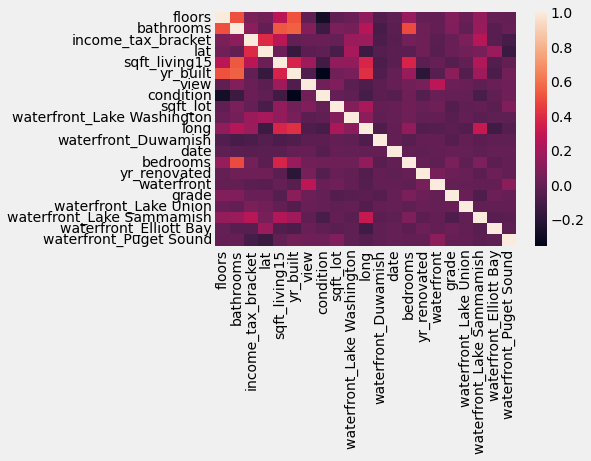

In [99]:
cor = X.corr()
sns.heatmap(cor,xticklabels=cor.columns,
        yticklabels=cor.columns)
plt.show()

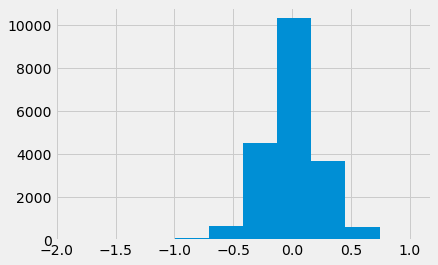

In [100]:
plt.hist(new_residuals)
plt.show()

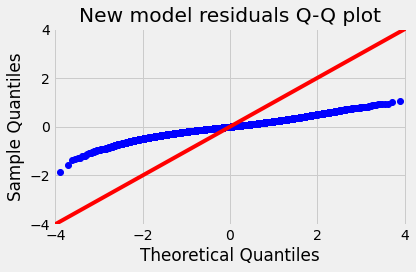

In [104]:
sm.qqplot(new_residuals, line ='45')

plt.title("New model residuals Q-Q plot")
plt.tight_layout()
plt.show()

In [101]:
ind_dict = model_strength_indicators(new_model)
ind_dict

{'r_squared': '0.715',
 'skew': '-0.139',
 'kurtosis': '4.634',
 'Durbin Watson': '1.990',
 'Jarque-Bera': '2288.207',
 'P value': '0.000',
 'Condition': '4888653119'}

In [102]:
new_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.716
Model:                            OLS   Adj. R-squared:                  0.715
Method:                 Least Squares   F-statistic:                     2391.
Date:                Tue, 05 Apr 2022   Prob (F-statistic):               0.00
Time:                        14:17:39   Log-Likelihood:                 428.70
No. Observations:               19982   AIC:                            -813.4
Df Residuals:                   19960   BIC:                            -639.5
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                       -202.2669     11.139    -18.158      0.000    -224.101    -180.433
floors                         0.1006      0.004     25.509      0.000       0.093       0.108
bathrooms                      0.1479      0.004     40.470      0.000       0.141       0.155
income_tax_bracket             0.2513      0.004     68.018      0.000       0.244       0.259
lat                            1.1099      0.014     79.292      0.000       1.082       1.137
sqft_living15                  0.0002   3.65e-06     67.669      0.000       0.000       0.000
yr_built                      -0.0016   8.86e-05    -18.357      0.000      -0.002      -0.001
view                           0.0650      0.003     22.658      0.000       0.059       0.071
condition                      0.0640      0.003     22.272      0.000       0.058       0.070
sqft_lot                    9.769e-07   4.38e-08     22.321      0.000    8.91e-07    1.06e-06
waterfront_Lake Washington    -0.2542      0.012    -21.179      0.000      -0.278      -0.231
long                          -0.2797      0.015    -19.000      0.000      -0.309      -0.251
waterfront_Duwamish           -0.2422      0.015    -16.211      0.000      -0.272      -0.213
date                           0.0002   1.49e-05     11.823      0.000       0.000       0.000
bedrooms                       0.0251      0.002     11.393      0.000       0.021       0.029
yr_renovated                4.283e-05   5.15e-06      8.320      0.000    3.27e-05    5.29e-05
waterfront                     0.2817      0.035      7.988      0.000       0.213       0.351
grade                          0.0083      0.001      7.586      0.000       0.006       0.010
waterfront_Lake Union          0.1490      0.026      5.636      0.000       0.097       0.201
waterfront_Lake Sammamish      0.0306      0.008      3.660      0.000       0.014       0.047
waterfront_Elliott Bay         0.0366      0.011      3.447      0.001       0.016       0.057
waterfront_Puget Sound        -0.0492      0.013     -3.897      0.000      -0.074      -0.024
==============================================================================
Omnibus:                      796.862   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2288.207
Skew:                          -0.139   Prob(JB):                         0.00
Kurtosis:                       4.634   Cond. No.                     4.89e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.89e+09. This might indicate that there are
strong multicollinearity or other numerical problems.


##### Observations on final model
After experimenting with manual elimination of select features it appears that the model above (new_model) is about as strong as the model is going to get as it mostly satisfies the 4 assumptions of linear regressian and the further elimination of features appears to only strengthen narrow aspects of the model at the expense of weakening the model broadly. 

regarding the 4 assumptions:
- The model has been thoroughly inspected for colinearity using multiple methods of measurment and has been exhaustively fitted for the colinearity assumption. 
- The model's Durbin-Watson score suggests strong homoscedasticity
- The model's coefficients generally show a meaninful linear relatioship within the model
- 